In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/content/drive/MyDrive/asl_dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='training',
                                             seed=42, label_mode='categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='validation',
                                             seed=42, label_mode='categorical')

Found 2515 files belonging to 36 classes.
Using 1761 files for training.
Found 2515 files belonging to 36 classes.
Using 754 files for validation.


TypeError: ignored

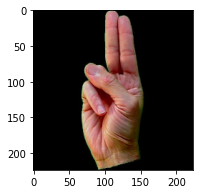

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation


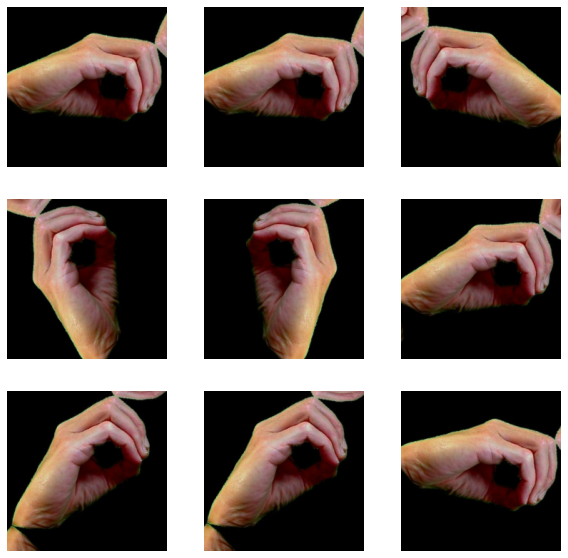

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionResNetV2(input_tensor=tfl.Input(shape=IMG_SHAPE),
                                               include_top=True,
                                               weights="imagenet")


225222656/225209952 [==============================] - 1s 0us/step


In [10]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [11]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

avg_pool
predictions


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [13]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)
tf.keras.applications.mobilenet_v3.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n02786058', 'Band_Aid', 0.99998915), ('n03929660', 'pick', 1.4947399e-06)],
 [('n02786058', 'Band_Aid', 0.3104779), ('n03929660', 'pick', 0.12633592)],
 [('n02786058', 'Band_Aid', 0.99343383),
  ('n04376876', 'syringe', 0.0011384513)],
 [('n02786058', 'Band_Aid', 0.9987381), ('n03929660', 'pick', 0.00030002298)],
 [('n02786058', 'Band_Aid', 0.9999995),
  ('n04376876', 'syringe', 1.5868468e-07)],
 [('n01728920', 'ringneck_snake', 0.30107725),
  ('n01776313', 'tick', 0.1815092)],
 [('n02786058', 'Band_Aid', 0.99998736),
  ('n01728572', 'thunder_snake', 5.25197e-06)],
 [('n04074963', 'remote_control', 0.42008397),
  ('n03929660', 'pick', 0.13404556)],
 [('n02786058', 'Band_Aid', 0.99834347), ('n03929660', 'pick', 0.00021198476)],
 [('n02786058', 'Band_Aid', 0.94162863), ('n01776313', 'tick', 0.009131279)],
 [('n03929660', 'pick', 0.27742538), ('n02786058', 'Band_Aid', 0.2397814)],
 [('n02786058', 'Band_Aid', 0.99993026),
  ('n02667093', 'abaya', 7.1399554e-06)],
 [('n03929660', 'pick'

In [14]:
def asl_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.InceptionResNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet' , pooling= 'avg')
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x) 
  x = base_model(x)
  
  prediction_layer = tfl.Dense(36,activation="softmax")
  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)
  return model


In [20]:
with tf.device('/device:GPU:0'):
  model = asl_model(IMG_SIZE, data_augmentation)
  lr = 1e-3
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                           

In [22]:
with tf.device('/device:GPU:0'):
  initial_epochs = 50
  history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
56/56 [==============================] - 28s 335ms/step - loss: 3.1159 - accuracy: 0.1721 - val_loss: 2.5837 - val_accuracy: 0.2958
Epoch 2/50
56/56 [==============================] - 16s 274ms/step - loss: 2.1537 - accuracy: 0.3907 - val_loss: 2.1444 - val_accuracy: 0.3833
Epoch 3/50
56/56 [==============================] - 17s 288ms/step - loss: 1.8484 - accuracy: 0.4560 - val_loss: 1.9852 - val_accuracy: 0.3979
Epoch 4/50
56/56 [==============================] - 16s 280ms/step - loss: 1.5783 - accuracy: 0.5520 - val_loss: 1.5897 - val_accuracy: 0.5690
Epoch 5/50
56/56 [==============================] - 17s 284ms/step - loss: 1.4051 - accuracy: 0.5963 - val_loss: 1.6195 - val_accuracy: 0.5172
Epoch 6/50
56/56 [==============================] - 16s 278ms/step - loss: 1.3339 - accuracy: 0.6161 - val_loss: 1.3797 - val_accuracy: 0.5955
Epoch 7/50
56/56 [==============================] - 16s 280ms/step - loss: 1.2611 - accuracy: 0.6241 - val_loss: 1.3381 - val_accuracy: 0.6406

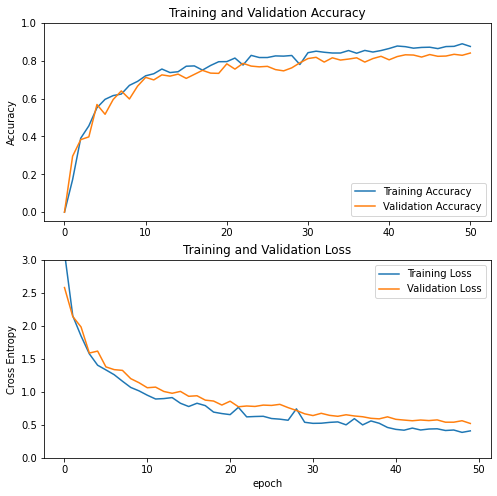

In [23]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()